# Análise Exploratória dos Dados - Fases 1 e 2

In [1]:
!pip install sklearn-crfsuite

     |████████████████████████████████| 743 kB 5.3 MB/s 


In [2]:
import operator
import os
import random
import functools
import collections
import numpy as np
import matplotlib.pyplot as plt
import nltk
import sklearn_crfsuite
import pandas as pd
import joblib

from nltk.tag.hmm import HiddenMarkovModelTrainer
from sklearn.model_selection import KFold
from itertools import chain
from nltk.corpus import PlaintextCorpusReader 
from nltk import sent_tokenize, word_tokenize, pos_tag 
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')

random.seed(1999)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


---
(1) DIR é o caminho para um folder contendo todos os arquivos no formato .conll

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#tipos
#DIR = '/content/drive/MyDrive/UFRPE_Shared/Doutorado/Anotações Inception/Anotações_Scripts/Fase2/1_CategoriasCorrigidas/'
#categorias
DIR = '/content/drive/MyDrive/UFRPE_Shared/Doutorado/Anotações Inception/Anotações_Scripts/Fase2/2_Categorias_Joined/'
all_files = os.listdir(DIR)


---
(2) **def process\_conll\_file:** 
  transforma arquivos no formato .conll em listas aninhadas com a seguinte hierarquia:
  - Nível 1: Sentenças
  - Nível 2: Tuplas do tipo (Token, Tag)

In [6]:
def process_conll_file(location:str)->list:
    with open(location, "r") as f:
        data = f.read()
    data = data.split("\n\n")
    data = list(map(lambda x:x.split("\n"), data))
    data.pop()
    data = list(map(lambda x:[operator.itemgetter(*[0, -1])(y.split(" ")) for y in x], data))
    return data

---
(3) **def combine\_files:** faz o merge dos outputs da função process\_conll\_file, agora ao invés da lista conter as sentenças de um único arquivo, contém as sentenças de todos os arquivos em DIR.

In [7]:
def combine_files(locations:list)->list:
    extended = []
    for f in locations:
        f = DIR + f
        extended.extend(process_conll_file(f))
    return extended

In [8]:
#main1
all_data = combine_files(all_files)
random.shuffle(all_data)
f"Número Total de Documentos: {len(all_data)}"

'Número Total de Documentos: 7109'

## Estatísticas sobre as sentenças

---
(4) box plot da distribuição das sentenças.

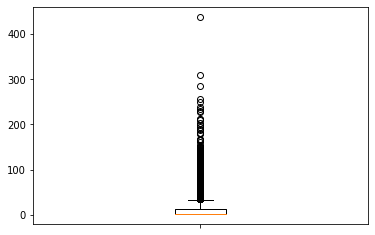

In [9]:
tamanhos_sent = []
for d in all_data:
  tamanhos_sent.append(len(d))  
plt.boxplot(tamanhos_sent, labels=[""])
plt.show()

---
(5) Estimação pontual do número médio de tokens por sentença com intervalo de confiança.

In [10]:
media_sent = np.mean(tamanhos_sent)
std_sent = np.std(tamanhos_sent)
z_alpha = 1.96
rng = (z_alpha * std_sent) / np.sqrt(len(tamanhos_sent))
print(f"Número Médio de Tokens por sentença: {media_sent}")
print(f"Intervalo de Confiança (alpha = 5%): {(media_sent-rng, media_sent+rng)}")

Número Médio de Tokens por sentença: 12.299198199465467
Intervalo de Confiança (alpha = 5%): (11.721068965203724, 12.87732743372721)


## Estatísticas sobre os tokens e tags

---
(6) **def to\_list**: remove a hierarquia das sentenças, ou seja, os tokens tornam-se independentes um do outro.

(7) **def split\_words\_n\_tags**: retorna duas listas: Uma contendo todos os tokens do dataset e outra contendo suas respectivas tags respeitando a ordem.

In [11]:
def to_list(data:list)->list:
    return functools.reduce(operator.iconcat, data, [])

def split_words_n_tags(data:list)->tuple:
    words, tags = map(list, zip(*data))
    return words, tags 

In [12]:
all_pairs = to_list(all_data)
all_words, all_tags = split_words_n_tags(all_pairs)
f"Número de tokens no dataset: {len(all_words)}", f"Tamanho do Vocabulário: {len(set(all_words))}"

('Número de tokens no dataset: 87435', 'Tamanho do Vocabulário: 9346')

---
(8) Remoção dos prefixos I- e B- (para melhorar o modelo)

In [14]:
all_tags_limpo = []
for tag in all_tags:
    if tag=="O":
        all_tags_limpo.append(tag)
    elif tag.startswith("B-") or tag.startswith("I-"):
        all_tags_limpo.append(tag[2:])
    else:
        continue

f"Número de Categorias ou Tipos: {len(set(all_tags_limpo))}"

'Número de Categorias ou Tipos: 8'

---
(9) counter de tags

In [15]:
tag_hist = collections.Counter(all_tags_limpo)
tag_hist

Counter({'DATA': 621,
         'EVENTO': 27,
         'FUNDAMENTO': 4283,
         'LOCAL': 754,
         'O': 78821,
         'ORGANIZACAO': 1153,
         'PESSOA': 994,
         'PRODUTODELEI': 782})

(10) Estimação pontual das proporções de cada tag

In [16]:
prop = {key:(val/sum(tag_hist.values())) * 100 for key, val in tag_hist.items()}
prop = dict(sorted(prop.items(), key=lambda item: item[1]))
for key, val in prop.items():
    print(f"{key} & {val:.2f}\%\\\\")

EVENTO & 0.03\%\\
DATA & 0.71\%\\
LOCAL & 0.86\%\\
PRODUTODELEI & 0.89\%\\
PESSOA & 1.14\%\\
ORGANIZACAO & 1.32\%\\
FUNDAMENTO & 4.90\%\\
O & 90.15\%\\


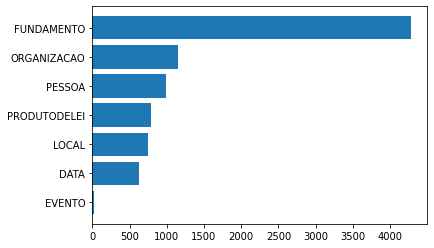

In [17]:
tag_hist.pop("O")
tag_hist = dict(sorted(tag_hist.items(), key=lambda item: item[1]))
keys = tag_hist.keys()
vals = tag_hist.values()

fig, ax = plt.subplots()
ax.barh(range(len(keys)), tag_hist.values())
ax.set_yticks(range(len(keys)))
ax.set_yticklabels(keys)
plt.show()

In [18]:
eps = z_alpha * np.sqrt(1/(4*len(all_words)))
print(f"Erro ao estimar a proporção (abordagem conservativa, alpha = 5%): {(eps * 100):.2f}%")

Erro ao estimar a proporção (abordagem conservativa, alpha = 5%): 0.33%


# Treinamento HMM

In [19]:
#main 2
all_data_hmm = combine_files(all_files)
random.shuffle(all_data_hmm)

In [20]:
train_size = int(0.75*len(all_data_hmm))
train = all_data_hmm[:train_size]
test = all_data_hmm[train_size:]
print("lembrar aqui:")
print(f"Tamanho do treino: {len(train)}")
print(f"Tamanho do teste: {len(test)}")

lembrar aqui:
Tamanho do treino: 5331
Tamanho do teste: 1778


In [21]:
# Remove o rótulo do conjunto de teste
def retrieve_sents(data:list)->list:
    return list(map(lambda x:[w for w,t in x], data))

In [23]:
# 5-fold no conjunto de treinamento
kfold = KFold(n_splits=5)
train = np.array(train, dtype=object)
i = 1
for t, tt in kfold.split(train):
    to_train = train[t].tolist()
    to_val = train[tt].tolist()
    unlab_test = retrieve_sents(to_val)
    hmm = HiddenMarkovModelTrainer().train_supervised(to_train)
    yhmm = hmm.tag_sents(unlab_test)
    hmm_file = ""
    for preds, true in zip(yhmm, to_val):
        for j in range(len(preds)):
            hmm_file += true[j][0] + " " + true[j][1] + " " + preds[j][1] + "\n"
        hmm_file += "\n"
    with open(f"/content/predictions_hmm/predictions_file_{i}", "w") as f:
        f.write(hmm_file)
    i += 1

In [24]:
unlab_test = retrieve_sents(test)
train = train.tolist()
hmm = HiddenMarkovModelTrainer().train_supervised(train)
yhmm = hmm.tag_sents(unlab_test)

In [25]:
print(unlab_test)
print(train)
print(yhmm)

[['.'], ['O', 'Congresso', 'Nacional', 'decreta', ':', 'Art', '.', '1º', 'Esta', 'lei', 'altera', 'o', '§', '3º', 'do', 'art', '.', '148', 'da', 'Lei', 'nº', '9.503', ',', 'de', '23', 'de', 'setembro', 'de', '1997', ',', 'que', 'institui', 'o', 'Código', 'de', 'Trânsito', 'Brasileiro', 'para', 'dispor', 'sobre', 'a', 'Permissão', 'para', 'Dirigir', '.'], ['.'], ['.'], ['.'], ['.'], ['.'], ['.'], ['.'], ['.'], ['.'], ['.'], ['.'], ['.'], ['Art', '.', '2', 'o', 'O', '§', '3º', 'do', 'art', '.', '10', 'da', 'Lei', '9.504', ',', 'de', '30', 'de', 'setembro', 'de', '1997', ',', 'passa', 'a', 'vigorar', 'com', 'a', 'redação', 'que', 'se', 'segue', ':', 'Art', '.', '10'], ['.'], ['.'], ['.'], ['.'], ['.'], ['.'], ['.'], ['.'], ['.'], ['.'], ['.'], ['.'], ['.'], ['(', 'NR', ')', 'P', 'L', 'n', '.4', '7', '8', '3', '/', '2', '0', '1', '9', 'A', 'p', 're', 's', 'e', 'n', 'ta', 'ç', 'ã', 'o', ':', '2', '9', '/', '0', '8', '/', '2', '0', '1', '9', '1', '6', ':', '4', '4', '2', '“', 'Art', '.', '14

In [26]:
for preds, true in zip(yhmm, test):
    for j in range(len(preds)):
        hmm_file += true[j][0] + " " + true[j][1] + " " + preds[j][1] + "\n"
    hmm_file += "\n"
with open("/content/predictions_hmm/predictions_file_final", "w") as f:
    f.write(hmm_file)

# PEARL

In [200]:
#rodar na máquina local e pegar os scores
#perl conlleval.perl < predictions_file_1 > scores_file_1

# Metricas

In [27]:
# Extrai as métricas overall do arquivo gerado pelo script conlleval.perl
def extract_info(file):
    d = pd.read_csv(file)
    d = d.iloc[0, 0].split(";")
    return [float(s.split(":")[1][:-1]) for s in d]

In [28]:
dir_scores = '/content/drive/MyDrive/UFRPE_Shared/Doutorado/Anotações Inception/Anotações_Scripts/files_to_metrics/'

m = np.array(
    [
        extract_info(dir_scores+"scores_file_1"),
        extract_info(dir_scores+"scores_file_2"),
        extract_info(dir_scores+"scores_file_3"),
        extract_info(dir_scores+"scores_file_4"),
        extract_info(dir_scores+"scores_file_5")
    ]
)

media = np.mean(m, axis=0)
desvio = np.std(m, axis=0)  

print(f"\
accuracy: ${media[0]:.2f} \pm {desvio[0]:.2f}$ \|\| \
precision: ${media[1]:.2f} \pm {desvio[1]:.2f}$ \|\| \
recall: ${media[2]:.2f} \pm {desvio[2]:.2f}$ \|\| \
FB1: ${media[3]:.2f} \pm {desvio[3]:.2f}$")

# x = 44.56  # Media 1
# y = 40.74  # Media 2
# n = 5      # Tamanho das amostras
# sx = 4.29  # Desvio Padrao 1
# sy = 1.83  # Desvio Padrao 2

# T = (x-y)/np.sqrt(sx**2/n + sy**2/n)  # Estatistica do teste t-student
# z = 2.77645  # Referencia alpha=0.05 e n-1=4 graus de liberdade

# Se |T|>z rejeita-se H0 (As médias são diferentes)
# print((T)>z)

accuracy: $93.25 \pm 0.54$ \|\| precision: $62.36 \pm 6.05$ \|\| recall: $29.03 \pm 3.46$ \|\| FB1: $39.48 \pm 3.95$


Salvar o arquivo scores_file_final com o resultado final. 
- resultado da célula acima é para usar no latex. salvar aqui.
  - Metricas HMM: accuracy: $93.25 \pm 0.54$ \|\| 'precision: $62.36 \pm 6.05$ \|\| 'recall: $29.03 \pm 3.46$ \|\| 'FB1: $39.48 \pm 3.95$
  - Métricas CRF:
- por precaução, renomear para scores_file_XXX_YYY (XXX:hmm ou crf - XXX categorias ou tipos)


---
# Treinamento CRF

In [30]:
#função do tamanho da palavra (returna True se for maior que 4)
def length(word):
    if len(word) >= 4: 
        tamanho = True
    else:
        tamanho = False
    return tamanho

teste_tagger = joblib.load('POS_tagger_brill.pkl')
def postag(word):
    phrase = word
    postag = teste_tagger.tag(word_tokenize(phrase))
    return postag[0][1]

In [31]:
#função do tamanho da palavra
def length(word):
    if len(word) >= 5: 
        tamanho = True
    else:
        tamanho = False
    return tamanho


In [32]:
#tamanho da setenca
def tamsent(sent,i):
    conta = []
    valor = []
    for i in range(len(sent)):
        conta.append(sent[i].count(sent[i][0]))
    valor = sum(conta)
    return valor


In [33]:
#frequencia da palavra na sentenca
def freqwordsent(sent,word):
    conta = []
    valor = []
    for j in range(len(sent)):
        conta.append(sent[j].count(word))
    valor = sum(conta)
    return valor


In [34]:
def word2features(sent, i):
    word = sent[i][0]  
    features = {
        'bias': 1.0,
        'word': word,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word[-1:]': word[-1:],        
        'word[:1]': word[:1],
        'word[:2]': word[:2],
        'word[:3]': word[:3],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag(word),
        'postag[:2]': postag(word)[:1],
        'postag[:2]': postag(word)[:2],
        'tamanho': length(word),
        'word.isalnum()' : word.isalnum(),
        'len(word)': len(word),
        'tamanho(sent)': tamsent(sent,i),
        'freqwordsent' : freqwordsent(sent,word),   
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word': word1,
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isdigit()': word1.isdigit(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag(word1),
            '-1:postag[:2]': postag(word1)[:1],
            '-1:postag[:2]': postag(word1)[:2],
            '-1:word[-3:]': word1[-3:],
            '-1:word[-2:]': word1[-2:],
            '-1:word[-1:]': word1[-1:],
            '-1:word[:1]': word1[:1],
            '-1:word[:2]': word1[:2],
            '-1:word[:3]': word1[:3],
            '-1:len(word)': len(word1),
            '-1:word.isalnum()' : word1.isalnum(),
        })
    else:
        features['Inicio'] = True

    if i > 1:
        word2 = sent[i-2][0]
        features.update({
            '-2:word': word2,
            '-2:word.lower()': word2.lower(),
            '-2:word.istitle()': word2.istitle(),
            '-2:word.isdigit()': word2.isdigit(),
            '-2:word.isupper()': word2.isupper(),
            '-2:postag': postag(word2),
            '-2:postag[:2]': postag(word2)[:2],
            '-2:word[-3:]': word2[-3:],
            '-2:word[-2:]': word2[-2:],
            '-2:word[-1:]': word2[-1:],
            '-2:word[:1]': word2[:1],
            '-2:word[:2]': word2[:2],
            '-2:word[:3]': word2[:3],
            '-2:len(word)': len(word2),
            '-2:word.isalnum()' : word2.isalnum(),

        })
    if i < len(sent)-1:
        word3 = sent[i+1][0]
        features.update({
            '+1:word': word3,
            '+1:word.lower()': word3.lower(),
            '+1:word.istitle()': word3.istitle(),
            '+1:word.isdigit()': word3.isdigit(),
            '+1:word.isupper()': word3.isupper(),
            '+1:postag': postag(word3),
            '+1:postag[:2]': postag(word3)[:2],
            '+1:word[-3:]': word3[-3:],
            '+1:word[-2:]': word3[-2:],
            '+1:word[-1:]': word3[-1:],
            '+1:word[:1]': word3[:1],
            '+1:word[:2]': word3[:2],
            '+1:word[:3]': word3[:3],
            '+1:len(word)': len(word3),
            '+1:word.isalnum()' : word3.isalnum()
            })
    else:
        features['Final'] = True
   
    if i < len(sent)-2:
        word4 = sent[i+2][0]
        features.update({
            '+2:word': word4,
            '+2:word.lower()': word4.lower(),
            '+2:word.istitle()': word4.istitle(),
            '+2:word.isdigit()': word4.isdigit(),
            '+2:word.isupper()': word4.isupper(),
            '+2:postag': postag(word4),
            '+2:postag[:2]': postag(word4)[:2],
            '+2:word[-3:]': word4[-3:],
            '+2:word[-2:]': word4[-2:],
            '+2:word[-1:]': word4[-1:],
            '+2:word[:1]': word4[:1],
            '+2:word[:2]': word4[:2],
            '+2:word[:3]': word4[:3],
            '+2:len(word)': len(word4),
            '+2:word.isalnum()' : word4.isalnum()
        })     

    return features

In [35]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]


In [36]:
#maincrf
lista = ['bias','word','word.lower()','word[-3:]','word[-2:]','word[-1:]','word[:1]','word[:2]','word[:3]',
        'word.isupper()','word.istitle()','word.isdigit()','postag','postag[:2]','postag[:2]','tamanho','word.isalnum()',
        'len(word)','tamanho(sent)','freqwordsent','-1:word','-1:word.lower()','-1:word.istitle()','-1:word.isdigit()',
        '-1:word.isupper()','-1:postag','-1:postag[:2]','-1:postag[:2]','-1:word[-3:]','-1:word[-2:]','-1:word[-1:]',
        '-1:word[:1]','-1:word[:2]','-1:word[:3]','-1:len(word)','-1:word.isalnum()','-2:word','-2:word.lower()','-2:word.istitle()',
        '-2:word.isdigit()','-2:word.isupper()','-2:postag','-2:postag[:2]','-2:word[-3:]','-2:word[-2:]','-2:word[-1:]',
        '-2:word[:1]','-2:word[:2]','-2:word[:3]','-2:len(word)','-2:word.isalnum()','+1:word','+1:word.lower()',
        '+1:word.istitle()','+1:word.isdigit()','+1:word.isupper()','+1:postag','+1:postag[:2]','+1:word[-3:]','+1:word[-2:]',
        '+1:word[-1:]','+1:word[:1]','+1:word[:2]','+1:word[:3]','+1:len(word)','+1:word.isalnum()','+2:word',
        '+2:word.lower()','+2:word.istitle()','+2:word.isdigit()','+2:word.isupper()','+2:postag','+2:postag[:2]','+2:word[-3:]',
        '+2:word[-2:]','+2:word[-1:]','+2:word[:1]','+2:word[:2]','+2:word[:3]','+2:len(word)','+2:word.isalnum()']

all_data_crf = combine_files(all_files)
random.shuffle(all_data_crf)

In [38]:
train_size = int(0.75*len(all_data_crf))
train_crf = all_data_crf[:train_size]
test = all_data_crf[train_size:]
print("lembrar aqui:")
print(f"Tamanho do treino: {len(train)}")
print(f"Tamanho do teste: {len(test)}")

lembrar aqui:
Tamanho do treino: 5331
Tamanho do teste: 1778


In [39]:
# 5-fold no conjunto de treinamento
kfold = KFold(n_splits=5)
train = np.array(train, dtype=object)
i = 1
for t, tt in kfold.split(train):
    to_train = train[t].tolist()
    to_val = train[tt].tolist()
    
    X_train = [sent2features(s) for s in to_train]
    y_train = [sent2labels(s) for s in to_train]

    X_test = [sent2features(s) for s in to_val]
    
    crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=0.9,
        c2=0.4,
        max_iterations=100,
        all_possible_transitions=True
    )
    crf.fit(X_train, y_train)
    
    ycrf = crf.predict(X_test)
    
    crf_file = ""
    for preds, true in zip(ycrf, to_val):
        for j in range(len(preds)):
            crf_file += true[j][0] + " " + true[j][1] + " " + preds[j] + "\n"
        crf_file += "\n"
    with open(f"/content/predictions_crf/predictions_file_{i}", "w") as f:
        f.write(crf_file)
    i += 1
